### Compute the detuning with amplitude

- Compute the detuning with amplitude from the turn by turn data using NAFF.
- The motion is restricted in the horizontal or vertical plane (1D motion).


In [1]:
import pickle
import numpy as np
from math import *
import NAFFlib as pnf
import matplotlib.pyplot as plt

In [2]:
params = {'legend.fontsize': 20,
          'figure.figsize': (9.5, 8.5),
          'axes.labelsize': 27,
          'axes.titlesize': 23,
          'xtick.labelsize': 27,
          'ytick.labelsize': 27,
          'image.cmap': 'jet',
          'lines.linewidth': 1,
          'lines.markersize': 5,
          'font.family': 'sans-serif'}

plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rcParams.update(params)

#### Simulation parameters

In [3]:
n_turns = 1000
n_particles = 1000
# The following parameters are obtained from the twiss.tfs MAD-X file
Qx0 = 0.13 # decimal part of the nominal tune
Qy0 = 0.18
beta_x = 29.23897404
beta_y = 76.07315729
alpha_x = -0.8757651182
alpha_y = 1.898525134 
plane_of_study = 'x' # 'x'

In [6]:
path_to_data = '/afs/cern.ch/work/n/natriant/private/sixtracklib_example_crabcavity/output/'
data_file_name = 'tbt_{}.pkl'.format(plane_of_study)

In [7]:
my_dict = pickle.load( open( path_to_data+data_file_name, 'rb'))

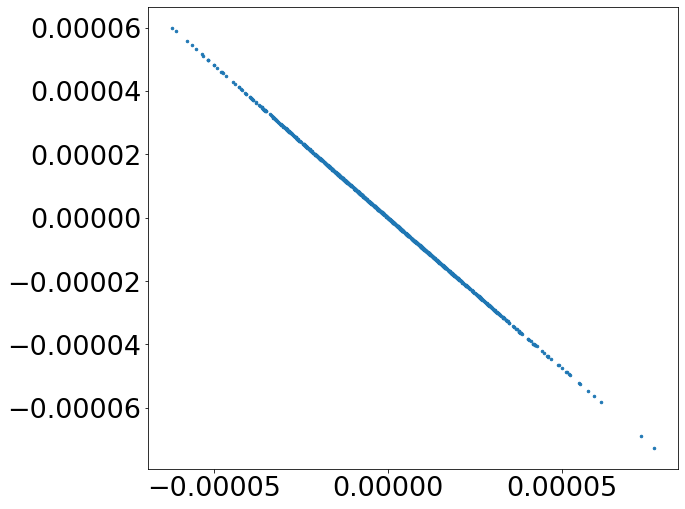

In [9]:
plt.plot(my_dict['{}'.format(plane_of_study)][0], my_dict['p{}'.format(plane_of_study)][0], '.')

### Tune shift with amplitude
- The tbt data obtained from the simulation are grouped with respect to turns.
- We need to group them in a list for each particle.


(u, pu) <--> (x, px) or (y, py)

In [10]:
u_data = {}
pu_data = {}
for particle in range(n_particles):
    u_data[particle] = []
    pu_data[particle] = []

In [11]:
# maybe even 100 turns are enough
for particle in range(n_particles):
    for turn in range(n_turns):
        u_data[particle].append(my_dict['{}'.format(plane_of_study)][turn][particle])
        pu_data[particle].append(my_dict['p{}'.format(plane_of_study)][turn][particle])

#### Test the longitudinal plane

In [12]:
my_x_index = np.where(my_dict['{}'.format(plane_of_study)][0] == np.amin(my_dict['{}'.format(plane_of_study)][0]))[0][0]
print(my_x_index)

730


#### Identify wheather there are any lost particles

In [14]:
lost_particles = []
Q_list = []

for particle in range(n_particles):
    if np.isnan(u_data[particle]).any() or np.isnan(pu_data[particle]).any():
        lost_particles.append(particle)
        print('particle {} lost'.format(particle))
    else:        
        signal = u_data[particle]
        Q_list.append(pnf.get_tune(np.array(signal)))

### Use normalised coordiantes
\begin{equation}
x_{N} = \frac{x}{\sqrt{\beta(s)}} \\
px_{N} = px \cdot \sqrt{\beta(s)} + x \frac{\alpha(s)}{\sqrt{\beta(s)}}
\end{equation}

Same applies for the vertical plane x <--> y.

### Calculate initial actions Jx
\begin{equation}
J_x = \frac{x_{N}^2 + px_{N}^2}{2} 
\end{equation}

Same applies for the vertical plane x <--> y.

In [15]:
flag_initial_actions = True
if flag_initial_actions :
    if plane_of_study == 'x':
        beta = beta_x
        alpha = alpha_x
    else:
        beta = beta_y
        alpha = alpha_y
    
    
    
    u_norm = my_dict[plane_of_study][0]/sqrt(beta) # the index 0 corresponds to turn
    pu_norm = my_dict['p{}'.format(plane_of_study)][0]*sqrt(beta) + my_dict[plane_of_study][0]*alpha/sqrt(beta)
    
    
    J_initial = (u_norm**2 + pu_norm**2)
    print('J{}_min= {}, J{}_max={}'.format(plane_of_study, min(J_initial), plane_of_study, max(J_initial)))

Jx_min= 5.672383898871528e-16, Jx_max=1.6430368586157095e-07


In [18]:
# Find minimum and maximum action in the array 
J_max = np.amax(J_initial)
J_min = np.amin(J_initial)
# Find the indeces of the maximum and minimum action
index_Jmax = np.where(J_initial == np.amax(J_max))[0][0]
index_Jmin = np.where(J_initial == np.amin(J_min))[0][0]

In [19]:
DQ = Q_list[index_Jmax] - Q_list[index_Jmin]
print(DQ)

2.7515462127480905e-05


0.13002749040800288


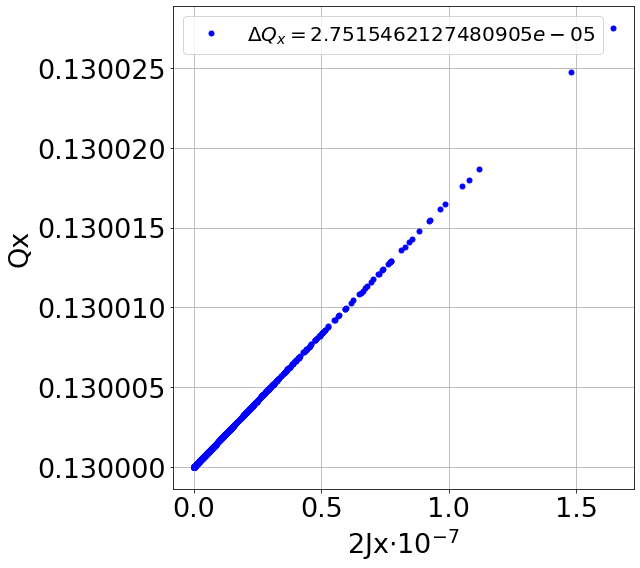

In [21]:
fig, ax = plt.subplots(1,1,figsize=(9,8))
print(max(Q_list))
ax.plot(np.array(J_initial)*1e7, Q_list, 'o', c='b', label = r'$\Delta Q_{}={}$'.format(plane_of_study, DQ)) # the index 0 corresponds to turn
ax.set_xlabel('2J{}'.format(plane_of_study) + r'$\cdot 10^{-7}$')
ax.set_ylabel('Q{}'.format(plane_of_study))
#ax.set_ylim(0.12997,0.13001)
plt.grid()
plt.legend(loc=0)
plt.tight_layout()
savefig = False
if savefig:
    plt.savefig('tune_shift.png')

###  Plot the detuning 

In [22]:
if plane_of_study == 'x':
        mytune = Qx0
if plane_of_study == 'y':
        mytune = Qy0
detuning = [i- mytune for i in Q_list]

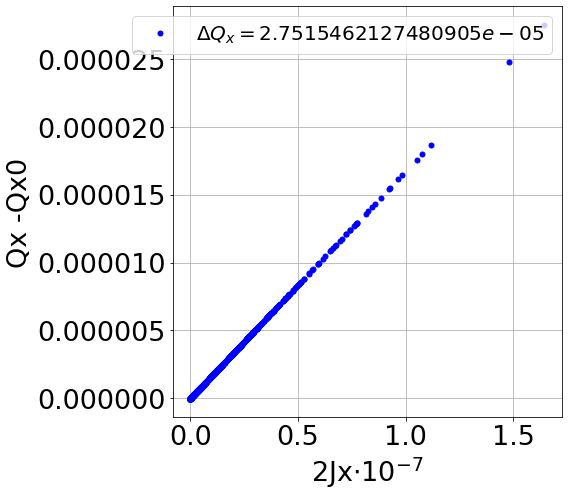

In [23]:
fig, ax = plt.subplots(1,1,figsize=(8,7))
ax.plot(np.array(J_initial)*1e7, detuning, 'o', c='b', label = r'$\Delta Q_{}={}$'.format(plane_of_study,DQ)) # the index 0 corresponds to turn
ax.set_xlabel('2J{}'.format(plane_of_study) + r'$\cdot 10^{-7}$')
ax.set_ylabel('Q{} -Q{}0'.format(plane_of_study, plane_of_study))
#ax.set_ylim(0.0,1e-4)
plt.tight_layout()
plt.grid()
plt.legend()
savefig = False
if savefig:
    plt.savefig('tune_shift.png')

#### Linear fit

In [24]:
[m_pn, b_pn], cov_pn = np.polyfit(J_initial, detuning, 1, cov=True)

In [25]:
m_pn # this is the detuning coefficient

167.37591866445965

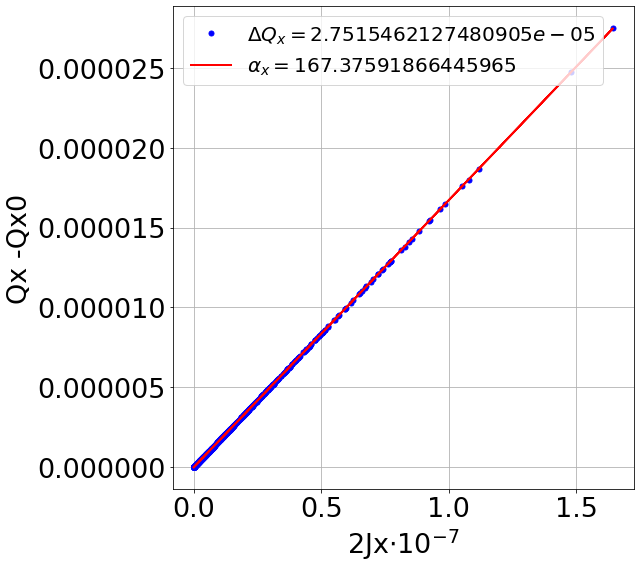

In [28]:
fig, ax = plt.subplots(1,1,figsize=(9,8))
ax.plot(np.array(J_initial)*1e7, detuning, 'o', c='b', label = r'$\Delta Q_{}={}$'.format(plane_of_study,DQ)) # the index 0 corresponds to turn
plt.plot(np.array(J_initial)*1e7, (m_pn*J_initial+b_pn), c = 'r', linewidth=2, label=r'$\alpha_{}={}$'.format(plane_of_study, m_pn))
ax.set_xlabel('2J{}'.format(plane_of_study) + r'$\cdot 10^{-7}$')
ax.set_ylabel('Q{} -Q{}0'.format(plane_of_study, plane_of_study))
#ax.set_ylim(0.0,1e-4)
plt.tight_layout()
plt.grid()
plt.legend()
savefig = False
if savefig:
    plt.savefig('tune_shift_{}.png'.format(plane_of_study))